
## Notebook Imports

In [1]:
import pandas as pd
from os import walk
from os.path import join 
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

import numpy as np

%matplotlib inline

In [2]:
# DEFAULT FILE SYSTEM ENCODING
import sys
sys.getfilesystemencoding()

'utf-8'

## Storing Constants

In [89]:
EXAMPLE_FILE='SpamData/01_Processing/practice_email.txt'
SPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH='SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT=1
HAM_CAT=0
VOCAB_SIZE = 2500

DATA_JSON_FILE= 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE= 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TESTING_DATA_FILE = 'SpamData/02_Training/test-data.txt'


WHALE_FILE_ICON= 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE_ICON = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'

THUMBS_UP_ICON = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_ICON = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'

FONT_PATH_BOLD = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files

In [4]:
stream=open(EXAMPLE_FILE,encoding='latin-1')
is_body=False
lines=[]
for line in stream:
    if is_body:
        lines.append(line)
    elif line=='\n':
        is_body=True
stream.close()

email_body='\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Email  Body Generation

In [5]:
def email_body_generator(path):
    
    for root,directory_names, filenames in walk(path):
        
        for filename in filenames:
            
            filepath=join(root,filename)
            stream=open(filepath,encoding='latin-1')
            is_body=False
            lines=[]
            
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line=='\n':
                    is_body=True
            
            stream.close()

            email_body='\n'.join(lines)
            
            yield filename, email_body

    

In [6]:
def df_from_directory(path,classification):
    rows=[]
    row_names=[]
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE':email_body, 'CATEGORY':classification})
        row_names.append(file_name)
    return pd.DataFrame(rows,index=row_names)

In [7]:
spam_emails=df_from_directory(SPAM_1_PATH, SPAM_CAT) #SPAM emails classified 1
spam_emails=spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


In [8]:
spam_emails.shape

(1898, 2)

In [9]:
nonspam_emails=df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
nonspam_emails=nonspam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
nonspam_emails.head()

,MESSAGE,CATEGORY
00001.7c53336b37003a9286aba55d2945844c,"Date: Wed, 21 Aug 2002 10:54:46 -05...",0
00002.9c4069e25e1ef370c078db7ee85ff9ac,"Martin A posted:\n\nTassos Papadopoulos, the G...",0
00003.860e3c3cee1b42ead714c5c874fe25f7,Man Threatens Explosion In Moscow \n\n\n\nThur...,0
00004.864220c5b6930b209cc287c361c99af1,Klez: The Virus That Won't Die\n\n \n\nAlready...,0
00005.bf27cdeaf0b8c4647ecd61b1d09da613,"> in adding cream to spaghetti carbonara, whi...",0


In [10]:
nonspam_emails.shape

(3901, 2)

In [11]:
data=pd.concat([spam_emails,nonspam_emails])
print('Shape of the entire dataframe is ', data.shape)
data.head()

Shape of the entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


## Data Cleaning: Removing null entries and missing values

In [12]:
data.MESSAGE

00001.7848dde101aa985090474a91ec93fcf0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
00002.d94f1b97e48ed3b553b3508d116e6a09    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724    ##############################################...
00005.57696a39d7d84318ce497886896bf90d    I thought you might like these:\n\n1) Slim Dow...
                                                                ...                        
01396.61983fbe6ec43f55fd44e30fce24ffa6    http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    > >-- be careful when using this one.) Also, t...
01398.169b51731fe569f42169ae8f948ec676    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    So then, "Mark Hammond" <mhammond@skippinet.co...
01400.f897f0931e461e7b2e964d28e927c35e    Hi there,\n\n\n\nNow this is probably 

In [13]:
data['MESSAGE']

00001.7848dde101aa985090474a91ec93fcf0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
00002.d94f1b97e48ed3b553b3508d116e6a09    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724    ##############################################...
00005.57696a39d7d84318ce497886896bf90d    I thought you might like these:\n\n1) Slim Dow...
                                                                ...                        
01396.61983fbe6ec43f55fd44e30fce24ffa6    http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    > >-- be careful when using this one.) Also, t...
01398.169b51731fe569f42169ae8f948ec676    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    So then, "Mark Hammond" <mhammond@skippinet.co...
01400.f897f0931e461e7b2e964d28e927c35e    Hi there,\n\n\n\nNow this is probably 

In [14]:
data.MESSAGE.isnull().values.any()  #Returns true if even 1 of them is null valued

False

In [15]:
# now check if empty emails, string len =0
(data.MESSAGE.str.len()==0).values.any()

True

In [16]:
(data.MESSAGE.str.len()==0).sum()

3

In [17]:
#NUMBER of entries with null values
(data.MESSAGE.isnull()==None).sum()

0

### Locating Empty Emails

In [18]:
type(data.MESSAGE.str.len()==0)

pandas.core.series.Series

In [19]:
data[data.MESSAGE.str.len()==0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

## Remove System File Entries from DataFrame

In [20]:
data=data.drop(['cmds']) #Alternatively use data.drop(['cmds'],inplace=True)
data.shape


(5796, 2)

## Adding Document IDs to track Emails

In [21]:
document_ids = range(0,len(data.index))
data['DOC_ID']=document_ids

In [22]:
data['FILENAME']=data.index
data.set_index('DOC_ID', inplace=True)

In [23]:
data.tail()

,MESSAGE,CATEGORY,FILENAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


## Save to a File using Pandas

In [24]:
data.to_json(DATA_JSON_FILE)

## Spam Message Data Visualisation

In [25]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [26]:
amount_of_spam=data.CATEGORY.value_counts()[1]
amount_of_nonspam=data.CATEGORY.value_counts()[0]

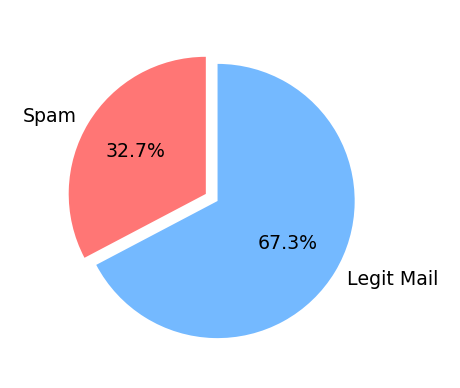

In [27]:
category_names=['Spam','Legit Mail']
sizes = [amount_of_spam,amount_of_nonspam]
custom_colors=['#ff7675','#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6},startangle=90, autopct='%1.1f%%', 
        colors=custom_colors, explode=[0, 0.1])
plt.show()

## Sample Donut Charts

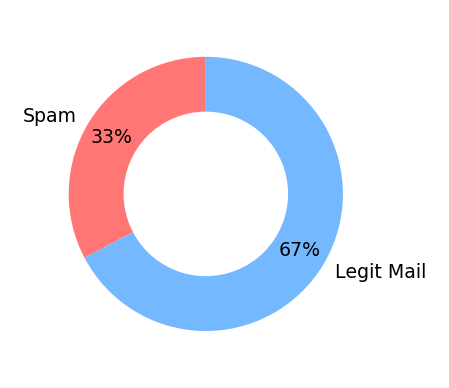

In [28]:
category_names=['Spam','Legit Mail']
sizes = [amount_of_spam,amount_of_nonspam]
custom_colors=['#ff7675','#74b9ff']

plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6},startangle=90, autopct='%1.0f%%', 
        colors=custom_colors, pctdistance=0.8)
# draw Circle
centre_circle=plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

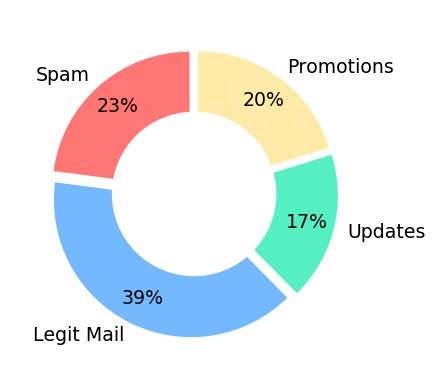

In [29]:
category_names=['Spam','Legit Mail','Updates','Promotions']
sizes = [25,43,19,22]
custom_colors=['#ff7675','#74b9ff','#55efc4','#ffeaa7']
offset=[0.05,0.05,0.05,0.05]
plt.figure(figsize=(2,2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6},startangle=90, autopct='%1.0f%%', 
        colors=custom_colors, pctdistance=0.8,explode=offset)
# draw Circle
centre_circle=plt.Circle((0,0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## Natural Language Processing (NLP)

### NLTK Resources (Tokenizer and Stopwords)

In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kanav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kanav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Kanav\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\Kanav\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

### Tokenising

In [33]:
msg='Natural Language Processing is an important part of a machine learning algorithm.'
word_tokenize(msg.lower())

['natural',
 'language',
 'processing',
 'is',
 'an',
 'important',
 'part',
 'of',
 'a',
 'machine',
 'learning',
 'algorithm',
 '.']

### Removing stopwords

In [34]:
stop_words=set(stopwords.words('english'))

In [35]:
words=word_tokenize(msg.lower())
filtered_words=[]
for x in words:
    if x not in stop_words:
        filtered_words.append(x)
print(filtered_words)

['natural', 'language', 'processing', 'important', 'part', 'machine', 'learning', 'algorithm', '.']


### Stemming 

In [36]:
words=word_tokenize(msg.lower())

stemmer=PorterStemmer()

filtered_words=[]
for x in words:
    if x not in stop_words:
        stemmed_word=stemmer.stem(x)
        filtered_words.append(stemmed_word)
print(filtered_words)

['natur', 'languag', 'process', 'import', 'part', 'machin', 'learn', 'algorithm', '.']


### Removing Punctuation

In [37]:
words=word_tokenize(msg.lower())

stemmer=PorterStemmer()

filtered_words=[]
for x in words:
    if x not in stop_words and x.isalpha(): # isalpha gives true if x isn't a punctuation mark
        stemmed_word=stemmer.stem(x)
        filtered_words.append(stemmed_word)

print(filtered_words)

['natur', 'languag', 'process', 'import', 'part', 'machin', 'learn', 'algorithm']


### Removing HTML from Emails

In [38]:
soup=BeautifulSoup( data.at[ 0, 'MESSAGE'], 'html.parser')
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

### Processing Emails

In [39]:
def clean_message(message, stemmer = PorterStemmer(), stop_words=set(stopwords.words('english'))):
    
    words=word_tokenize(message.lower())
    
    filtered_words=[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [40]:
print(clean_message(email_body))

['dear', 'mr', 'still', 'good', 'tide', 'staff', 'festiv', 'season', 'ahead', 'christma', 'crux', 'fulli', 'qualifi', 'santa', 'clau', 'wonder', 'whether', 'might', 'consid', 'run', 'santa', 'grotto', 'store', 'wait', 'probabl', 'think', 'make', 'special', 'well', 'first', 'made', 'sever', 'chang', 'characteris', 'father', 'christma', 'rather', 'greet', 'children', 'shout', 'ho', 'ho', 'ho', 'prefer', 'whisper', 'phrase', 'depend', 'unfathom', 'cruel', 'world', 'live', 'addit', 'gift', 'rang', 'felt', 'hoop', 'holder', 'note', 'also', 'enclos', 'sketch', 'radic', 'redesign', 'santa', 'outfit', 'renam', 'charact', 'lord', 'buckl', 'would', 'interest', 'employ', 'promis', 'never', 'let', 'look', 'forward', 'hear', 'best', 'wish', 'robin', 'cooper', 'excerpt', 'book', 'timewast', 'letter', 'robin', 'cooper']


In [41]:
def clean_message_html(message, stemmer = PorterStemmer(), stop_words=set(stopwords.words('english'))):
    soup=BeautifulSoup(message,'html.parser')
    
    words=word_tokenize(soup.get_text().lower())
    
    filtered_words=[]
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [42]:
print(clean_message_html(data.at[0, 'MESSAGE']))

['save', 'life', 'insur', 'spend', 'life', 'quot', 'save', 'g', 'famili', 'financi', 'secur', 'import', 'life', 'quot', 'save', 'ke', 'buy', 'life', 'insur', 'simpl', 'afford', 'provid', 'free', 'access', 'best', 'compani', 'lowest', 'rate', 'life', 'quot', 'save', 'fast', 'save', 'money', 'let', 'us', 'help', 'get', 'start', 'best', 'ue', 'countri', 'new', 'coverag', 'save', 'hundr', 'even', 'usand', 'dollar', 'request', 'free', 'quot', 'lifequot', 'save', 'servic', 'take', 'less', 'minut', 'complet', 'shop', 'compar', 'save', 'type', 'life', 'insur', 'click', 'free', 'quot', 'protect', 'famili', 'best', 'invest', 'r', 'make', 'receipt', 'email', 'error', 'wish', 'remov', 'list', 'pleas', 'click', 'type', 'remov', 'resid', 'state', 'prohibit', 'solicit', 'ce', 'pleas', 'disregard', 'email']


 ## Cleaning and Tokenising all Messages

### Functions on DataFrames

In [43]:
data.iat[2,2] # at[] goes by rownumber, column name, iat[] goes by index(rownum, columnum)

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [44]:
data.iloc[0:2] # gives me first two rows

,MESSAGE,CATEGORY,FILENAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09


In [45]:
%%time 

#using apply to all email messages in 'data'
nested_list=data.MESSAGE.apply(clean_message_html)

C:\Users\Kanav\anaconda3\lib\site-packages\bs4\__init__.py:424: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning


Wall time: 40.6 s


In [46]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

### Slicing DataFrames with Logic

In [47]:
data[data.CATEGORY==0].shape

(3900, 3)

In [48]:
doc_ids_spam = data[data.CATEGORY==1].index
doc_ids_nonspam = data[data.CATEGORY==0].index

### Subsetting series with index

In [49]:
nested_list_nonspam=nested_list.loc[doc_ids_nonspam]
nested_list_spam=nested_list.loc[doc_ids_spam]

In [50]:
nested_list_nonspam.shape

(3900,)

In [51]:
spam_list=[item for spam_mail in nested_list_spam for item in spam_mail]
spam_words = pd.Series(spam_list).value_counts()#value_counts() counts distinct words number

nonspam_list=[item for nonspam_mail in nested_list_nonspam for item in nonspam_mail]
nonspam_words=pd.Series(nonspam_list).value_counts()

## Creating a Word Cloud

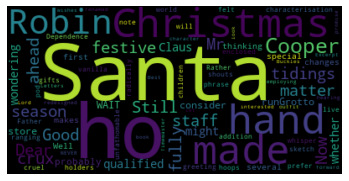

In [52]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [53]:
example_corpus=nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

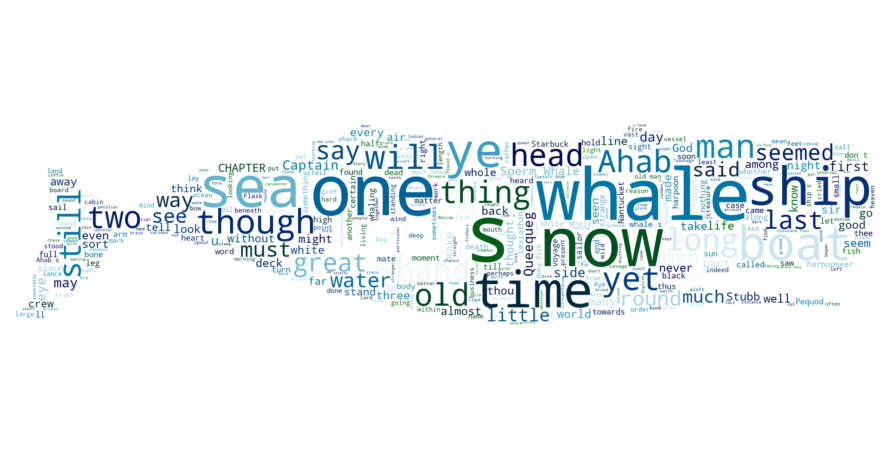

In [54]:
word_list=[''.join(word) for word in example_corpus]
novel=' '.join(word_list)

icon = Image.open(WHALE_FILE_ICON)
image_mask = Image.new(mode='RGB', size = icon.size, color= (255, 255, 255) )
image_mask.paste(icon, box = icon)
rgb_array = np.array(image_mask)   # Converts image object to the array reqd.


word_cloud=WordCloud(mask= rgb_array, background_color='white', max_words=400, colormap='ocean')
word_cloud.generate(novel)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

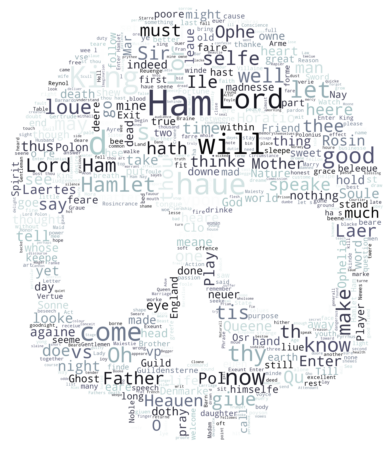

In [55]:
## Doing same for a different novel

example_corpus=nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
len(example_corpus)

word_list=[''.join(word) for word in example_corpus]
novel=' '.join(word_list)

icon = Image.open(SKULL_FILE_ICON)
image_mask = Image.new(mode='RGB', size = icon.size, color= (255, 255, 255) )
image_mask.paste(icon, box = icon)
rgb_array = np.array(image_mask)   # Converts image object to the array reqd.


word_cloud=WordCloud(mask= rgb_array, background_color='white', max_words=600, colormap='bone')
word_cloud.generate(novel)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [56]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

## WordCloud for Spam and Non-Spam Messages

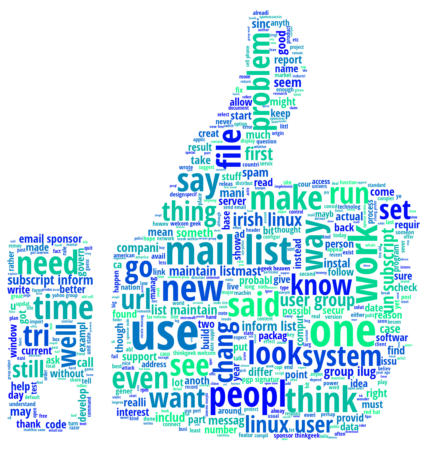

In [57]:
icon = Image.open(THUMBS_UP_ICON)
image_mask = Image.new(mode='RGB', size = icon.size, color= (255, 255, 255) )
image_mask.paste(icon, box = icon)
rgb_array = np.array(image_mask)   # Converts image object to the array reqd.

nonspam_str = ' '.join(nonspam_list)

word_cloud=WordCloud(mask= rgb_array, background_color='white', max_words=500, colormap='winter', font_path=FONT_PATH_BOLD)
word_cloud.generate(nonspam_str)
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

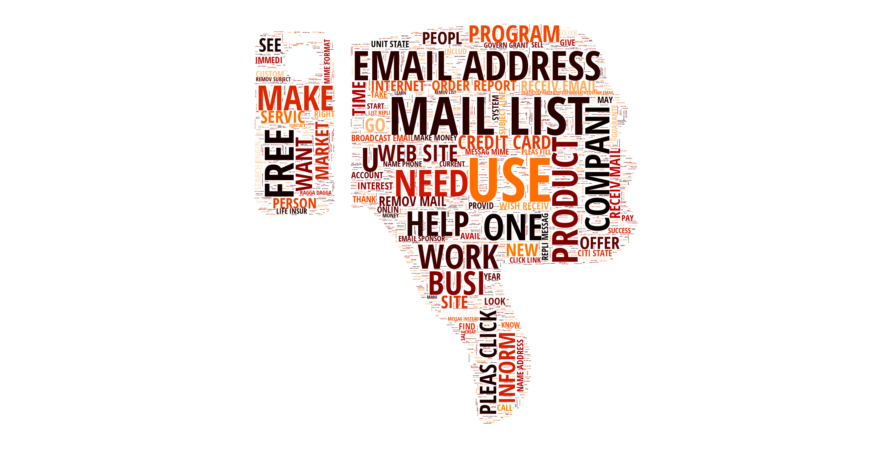

In [58]:
icon = Image.open(THUMBS_DOWN_ICON)
image_mask = Image.new(mode='RGB', size = icon.size, color= (255, 255, 255) )
image_mask.paste(icon, box = icon)
rgb_array = np.array(image_mask)   # Converts image object to the array reqd.

spam_str = ' '.join(spam_list)

word_cloud=WordCloud(mask= rgb_array, background_color='white', max_words=2000, colormap='gist_heat', font_path=FONT_PATH_BOLD)
word_cloud.generate(spam_str.upper())
plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generating Vocab and Dictionary for Classifier

In [59]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_html)
stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [60]:
unique_words = pd.Series(stemmed_list).value_counts()
print('No of unique words ', unique_words.shape[0])
unique_words.head()

No of unique words  27218


http     10648
use       5015
list      4849
email     4366
get       4187
dtype: int64

In [61]:
frequent_words = unique_words[:VOCAB_SIZE]
type(frequent_words)

pandas.core.series.Series

In [62]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'

vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Saving the vocab as a csv file

In [63]:
vocab.to_csv(WORD_ID_FILE, index_label= vocab.index.name, header = vocab.VOCAB_WORD.name)

## Generate Sparse Matrix 

In [64]:
type(stemmed_nested_list)

pandas.core.series.Series

In [65]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


## Splitting data into Training and Testing Dataset

In [66]:
x_train, x_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size = 0.3, random_state = 42)

In [67]:
print('Num of training samples is', x_train.shape[0])

Num of training samples is 4057


In [68]:
x_train.index.name = x_test.index.name = 'DOC_ID'
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [69]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

### Creating Sparse Matrix for the Training Data

In [72]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index[4]

'get'

In [73]:
word_index.get_loc('get')

4

In [74]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns Sparse Matrix as a dataframe.
    
    df: dataframe with words in columns with a document id as index (x_train or x_test)
    indexed_words: index of words ordered by word_id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    
    word_set = set(indexed_words)
    
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                        'OCCURRENCE': 1, 'WORD_ID': word_id}
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)
    

In [75]:
%%time 
sparse_train_df = make_sparse_matrix(x_train, word_index, y_train)
sparse_train_df.head()

Wall time: 3min 36s


,LABEL,DOC_ID,OCCURRENCE,WORD_ID
0,0,4844,1,265
1,0,4844,1,1256
2,0,4844,1,504
3,0,4844,1,308
4,0,4844,1,256


## Combine Occurences with pd.groupby()

In [77]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL' ]).sum()
train_grouped.head()

OCCURRENCE
DOC_ID WORD_ID LABEL            
0      2       1               1
       3       1               2
       4       1               1
       7       1               3
       11      1               1

In [78]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [80]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,0,2,1,1
1,0,3,1,2
2,0,4,1,1
3,0,7,1,3
4,0,11,1,1


In [81]:
train_grouped.shape

(257918, 4)

In [82]:
sparse_train_df.shape

(428371, 4)

### Save Training Data as .txt file

In [84]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt = '%d')

In [85]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURRENCE'], dtype='object')

### Doing the same thing for Test Data

In [86]:
%%time 
sparse_test_df = make_sparse_matrix(x_test, word_index, y_test)
sparse_test_df.head()

Wall time: 1min 24s


,LABEL,DOC_ID,OCCURRENCE,WORD_ID
0,0,4675,1,88
1,0,4675,1,298
2,0,4675,1,549
3,0,4675,1,84
4,0,4675,1,470


In [87]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL' ]).sum()
test_grouped.head()

OCCURRENCE
DOC_ID WORD_ID LABEL            
8      2       1               1
       3       1               4
       4       1               2
       5       1               1
       6       1               2

In [88]:
test_grouped = test_grouped.reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURRENCE
0,8,2,1,1
1,8,3,1,4
2,8,4,1,2
3,8,5,1,1
4,8,6,1,2


In [90]:
np.savetxt(TESTING_DATA_FILE, test_grouped, fmt = '%d')